In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install seaborn[stats]==0.12.2 seaborn[statsmodels]
!pip install u8darts[all]
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Using cached setuptools-69.2.0-py3-none-any.whl.metadata (6.3 kB)
Using cached setuptools-69.2.0-py3-none-any.whl (821 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!cp /content/drive/MyDrive/utils.py .
import utils

In [40]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Data/AutoGluon/PJM_Load_hourly.csv")
df.head()


,Datetime,PJM_Load_MW
0,4/1/1998 1:00,22259
1,4/1/1998 2:00,21244
2,4/1/1998 3:00,20651
3,4/1/1998 4:00,20421
4,4/1/1998 5:00,20713


In [41]:
# Create series data identifier
if not 'unique_id' in df:
  df.insert(0, "unique_id", "1")
df['Date'] = pd.to_datetime(df['Datetime'])
df['freq'] = 'H'
df['visits'] = df['PJM_Load_MW']

df.head()


,unique_id,Datetime,PJM_Load_MW,Date,freq,visits
0,1,4/1/1998 1:00,22259,1998-04-01 01:00:00,H,22259
1,1,4/1/1998 2:00,21244,1998-04-01 02:00:00,H,21244
2,1,4/1/1998 3:00,20651,1998-04-01 03:00:00,H,20651
3,1,4/1/1998 4:00,20421,1998-04-01 04:00:00,H,20421
4,1,4/1/1998 5:00,20713,1998-04-01 05:00:00,H,20713


In [51]:
TIME_COL = "Date"
TARGET = "visits"
FREQ = "H"
STATIC_COV = ["unique_id"]
FORECAST_HORIZON = 64

In [52]:
df = df[['unique_id', TIME_COL, TARGET]]
df.columns

Index(['unique_id', 'Date', 'visits'], dtype='object')

In [53]:
df.head()

,unique_id,Date,visits
0,1,1998-04-01 01:00:00,22259
1,1,1998-04-01 02:00:00,21244
2,1,1998-04-01 03:00:00,20651
3,1,1998-04-01 04:00:00,20421
4,1,1998-04-01 05:00:00,20713


In [54]:
print(min(df[TIME_COL]))
print(max(df[TIME_COL]))
print(f"Total Items: {len(df)}")

1998-04-01 01:00:00
2001-12-29 23:00:00
Total Items: 32847


In [55]:
train = df[df[TIME_COL] <= (max(df[TIME_COL])-pd.DateOffset(hours=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-pd.DateOffset(hours=FORECAST_HORIZON))]

# since we have several time series not all of them have the same number of weeks in the forecast set
print(f"Hours for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Hours for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Hours for training: 32783 from 1998-04-01 to 2001-12-27
Hours for testing: 64 from 2001-12-27 to 2001-12-29


In [56]:
from darts import TimeSeries

# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(
      df=train,
      group_cols=STATIC_COV,
      time_col=TIME_COL,
      value_cols=TARGET,
      freq=FREQ,
      fill_missing_dates=False,
      fillna_value=0)

In [57]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import MissingValuesFiller

# create dynamic covariates for each serie in the training darts
dynamic_covariates = []
for serie in train_darts:
    # add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        serie,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )


    # create covariates to fill with interpolation
    dyn_cov_interp = TimeSeries.from_dataframe(df, time_col=TIME_COL, freq=FREQ, fill_missing_dates=True)
    # covariate = covariate.stack(MissingValuesFiller().transform(dyn_cov_interp))

    dynamic_covariates.append(dyn_cov_interp)

In [58]:
import torch

from chronos import ChronosPipeline

# load model
pipeline_tiny = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

pipeline_large = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

# run forecast
forecast_tiny = []
forecast_large = []
for ts in train_darts:
    # tiny
    lower, mid, upper = utils.chronos_forecast(pipeline_tiny, ts.pd_dataframe().reset_index(), FORECAST_HORIZON, TARGET)
    forecast_tiny.append(utils.convert_forecast_to_pandas([lower, mid, upper], test))

    # large
    lower, mid, upper = utils.chronos_forecast(pipeline_large, ts.pd_dataframe().reset_index(), FORECAST_HORIZON, TARGET)
    forecast_large.append(utils.convert_forecast_to_pandas([lower, mid, upper], test))

# convert list to data frames
forecast_tiny = pd.concat(forecast_tiny)
forecast_large = pd.concat(forecast_large)

In [59]:
forecast_tiny.to_csv('chronos_tiny.csv', header=forecast_tiny.columns)
forecast_large.to_csv('chronos_large.csv', header=forecast_tiny.columns)

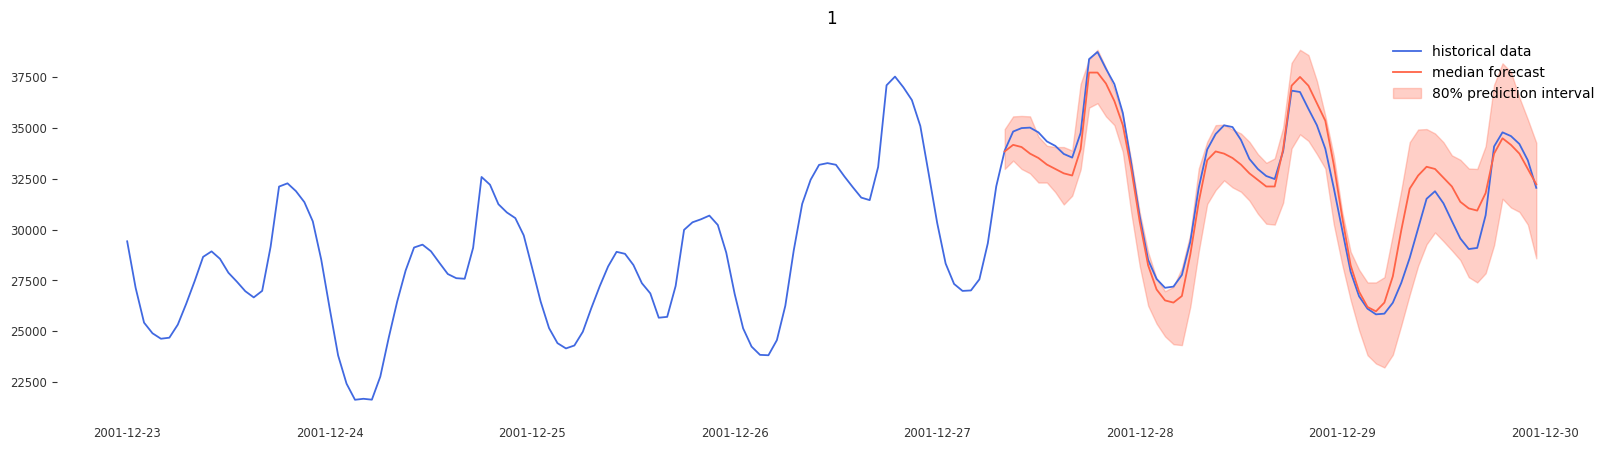

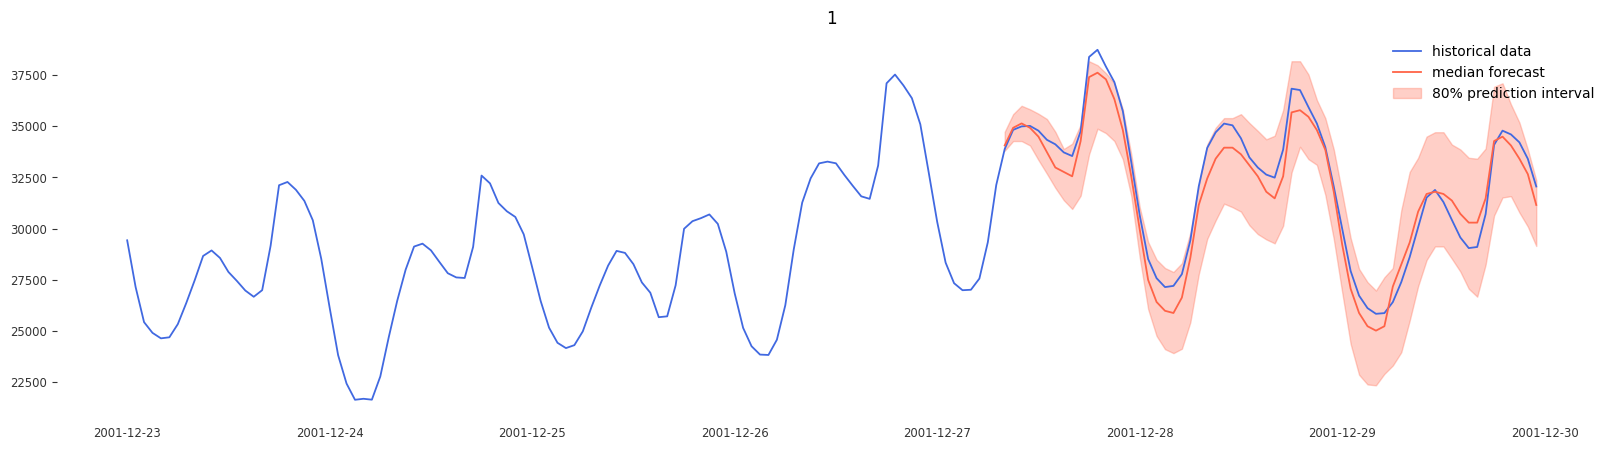

In [64]:
last_date = df['Date'].max()  # Get the last date of the dataframe
# Calculate the first date of the last quarter
first_date_last_quarter = last_date - pd.DateOffset(weeks=1)

# Now you modify the plotting loop to filter only the data within the last quarter
for ts in series[:3]:
    # Filter the actual data for the last quarter
    actuals_last_quarter = df[(df["unique_id"] == ts) & (df['Date'] > first_date_last_quarter)]
    # Filter the forecast data for the last quarter
    forecast_tiny_last_quarter = forecast_tiny[(forecast_tiny["unique_id"] == ts) & (forecast_tiny['Date'] > first_date_last_quarter)]
    forecast_large_last_quarter = forecast_large[(forecast_large["unique_id"] == ts) & (forecast_large['Date'] > first_date_last_quarter)]

    # Plotting the actuals and forecasts for the last quarter
    utils.plot_actuals_forecast(actuals_last_quarter, forecast_tiny_last_quarter, ts)
    utils.plot_actuals_forecast(actuals_last_quarter, forecast_large_last_quarter, ts)

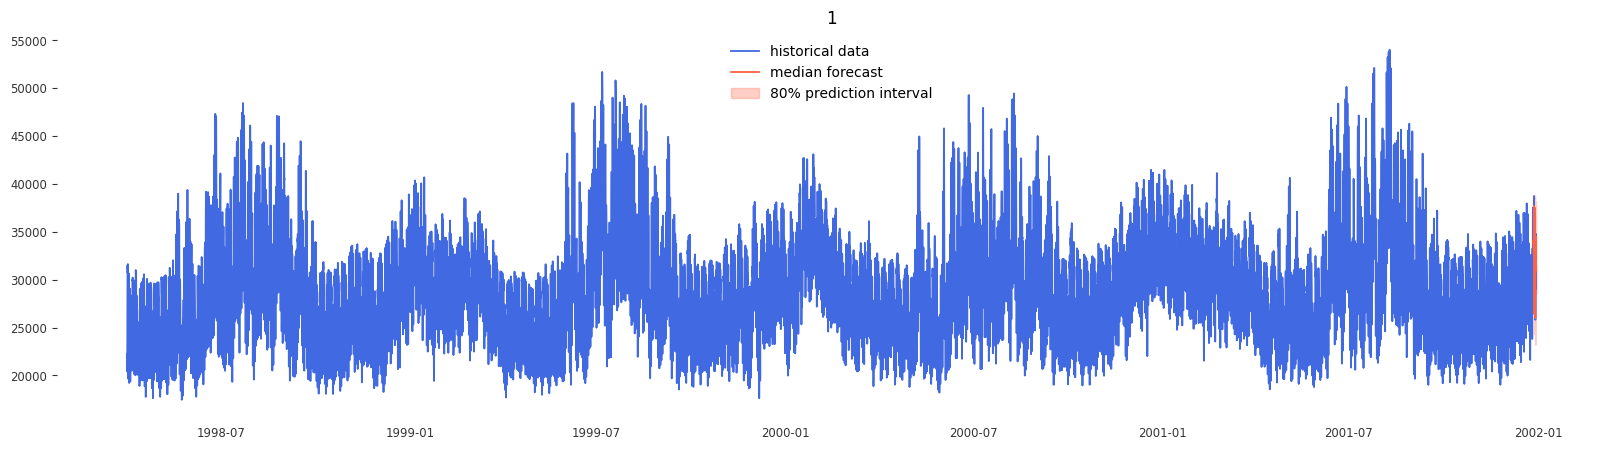

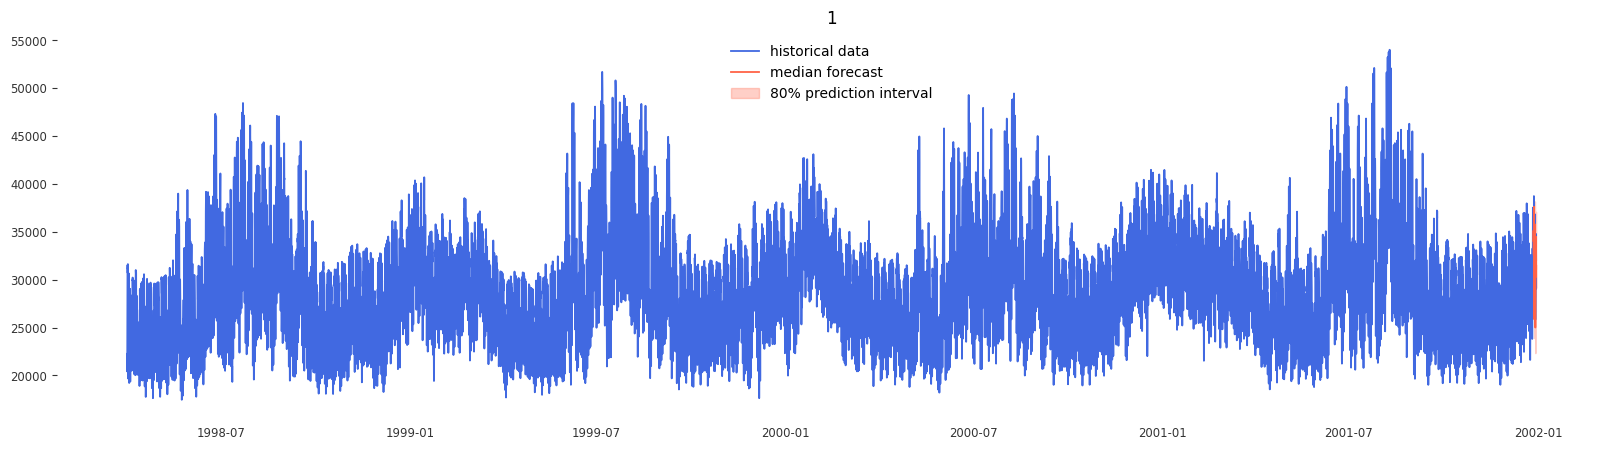

In [60]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

for ts in series[:3]:
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_tiny[forecast_tiny["unique_id"] == ts], ts)
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_large[forecast_large["unique_id"] == ts], ts)